In [4]:
import torch

In [52]:
import pandas as pd

frames = []
for f in ['file1.txt', 'file2.txt', 'file3.txt', 'file4.txt', 'file5.txt', 'file6.txt', 'file7.txt', 'file8.txt']:
    frames.append(pd.read_csv(f, sep=',', header=None, skiprows=1))

data = pd.concat(frames)

In [17]:
%matplotlib tk
from matplotlib import pyplot as plt
size = 600_000
start = 200_100
data[start:start+size].plot.scatter(x=0, y=3, s=[.01] * size)

<Axes: xlabel='0', ylabel='3'>

In [53]:
#X = torch.tensor([data[2], data[3]]).float()
data = data[data[1] != ' other']

classes = data[1].unique()
ctoi = {c: i for i, c in enumerate(classes)}
itoc = {i: c for i, c in enumerate(classes)}

X = torch.tensor(data[[2, 3]].values).float()

#Y = torch.tensor([ctoi[c] for c in data[1]]).float()
Y = torch.nn.functional.one_hot(torch.tensor([ctoi[c] for c in data[1]]), len(classes)).float()
ctoi, itoc

({' sniper': 0,
  ' scout': 1,
  ' engineer': 2,
  ' heavy': 3,
  ' pyro': 4,
  ' spy': 5,
  ' soldier': 6,
  ' medic': 7,
  ' demoman': 8},
 {0: ' sniper',
  1: ' scout',
  2: ' engineer',
  3: ' heavy',
  4: ' pyro',
  5: ' spy',
  6: ' soldier',
  7: ' medic',
  8: ' demoman'})

In [54]:
X.shape, Y.shape

(torch.Size([3300478, 2]), torch.Size([3300478, 9]))

In [55]:
# historgram of Y
Y.unique(dim=0,return_counts=True)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([ 150439,  108520,  813464,   65693,   24738,   48244,   52623, 1918728,
          118029]))

In [56]:
def split_data_batches(X, Y, ratio=0.8):
    n = int(X.size(0) * ratio)
    return (X[:n, :], Y[:n, :]), (X[n:, :], Y[n:, :])

(X_train, Y_train), (X_test, Y_test) = split_data_batches(X, Y)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([2640382, 2]),
 torch.Size([2640382, 9]),
 torch.Size([660096, 2]),
 torch.Size([660096, 9]))

In [57]:
block_size = 66 * 15
batch_size = 128

# grab random blocks of data from the training set
def get_time_series_batches(data, labels, batch_size, window_size):
    num_samples = data.size(0)
    num_windows = num_samples - window_size + 1
    batch_indices = torch.randint(0, num_windows, (batch_size,))
    xs = []
    ys = []
    for idx in batch_indices:
        x = data[idx:idx+window_size, :]
        y = labels[idx:idx+window_size, :]

        xs.append(x)
        ys.append(y)
        

    return torch.stack(xs), torch.stack(ys)


In [97]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc2 = torch.nn.LSTM(block_size * 2, 50, 2, batch_first=True, bidirectional=True)
        # expects B x C x T
        self.fc1 = torch.nn.Conv1d(2, 100, 66, stride=66)
        self.fc2 = torch.nn.Conv1d(100, 50, 3)
        self.drop = torch.nn.Dropout(0.75)
        #self.pool = torch.nn.MaxPool1d(2)
        self.flatten = torch.nn.Flatten()

        # input, hidden, layers
        #self.lstm = torch.nn.LSTM(650, 100, 2, batch_first=True, bidirectional=False)
        self.fc3 = torch.nn.Linear(650, 50)
        self.fc4 = torch.nn.Linear(50, Y.shape[1])
        #self.last = torch.nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 2, block_size)
        #x = x.reshape(-1, block_size * 2)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        #x = self.pool(x)
        #x = self.drop(x)
        x = self.flatten(x)
        
        #x,_ = self.lstm(x)
        #x = torch.relu(x)

        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        #x = torch.softmax(x, dim=1)
        #x = self.last(x)
        return x
    
net = Net()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [98]:
losses = []
validation_losses = []

In [99]:
optimizer.lr = 0.0001
for epoch in range(1000):
    optimizer.zero_grad()
    X_batch, Y_batch = get_time_series_batches(X_train, Y_train, batch_size, block_size)
    Y_pred = net(X_batch)
    Y_batch = Y_batch[:, -1, :]
    #Y_pred = Y_pred.view(-1, Y.shape[1])

    
    #print(X_batch.shape, Y_batch.shape, Y_pred.shape)
    l = loss(Y_pred, Y_batch)
    l.backward()
    optimizer.step()
    losses.append(l.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: {l.item()}')

    #print(Y_batch[:, :].argmax(dim=1).unique())
    with torch.no_grad():
        X_batch, Y_batch = get_time_series_batches(X_test, Y_test, batch_size, block_size)
        Y_pred = net(X_batch)
       # print(Y_pred.shape, Y_batch.shape)
        #Y_pred = Y_pred.view(-1, Y.shape[1])
        Y_batch = Y_batch[:, -1, :]
        #print(Y_pred.shape, Y_batch.shape)

        #Y_batch = Y_batch[:, 0, :]
        l = loss(Y_pred, Y_batch)
        validation_losses.append(l.item())

Epoch 0: 2.2764885425567627
Epoch 100: 2.137543201446533
Epoch 200: 2.1844096183776855
Epoch 300: 1.8719552755355835


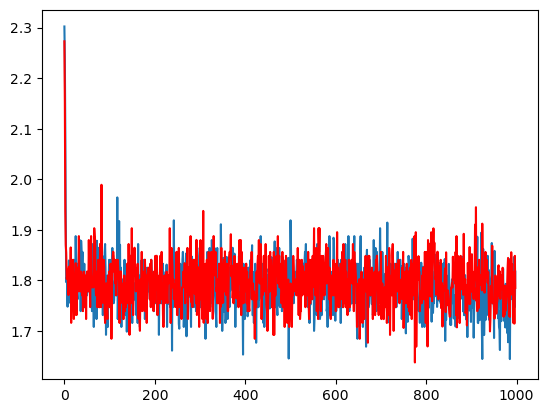

In [93]:
from matplotlib import pyplot as plt
plt.plot(torch.tensor(losses).reshape(-1,1).mean(dim=(1)), label='loss')
plt.plot(torch.tensor(validation_losses).reshape(-1,1).mean(dim=(1)), label='vloss', color='red')

In [94]:
#print(net(validation_x[1:2, :, :]), validation_y[1:2, 0, :])
print(net(validation_x[1:2, :, :]))
print(validation_y[1:2, 0, :])

tensor([[2.8669e-31, 1.0000e+00, 1.4212e-29, 5.3926e-29, 7.6315e-25, 1.3775e-41,
         4.6328e-28, 1.7594e-31, 5.0148e-25]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0.]])


performance history
####

  * 3 linear layers: loss: jittery around 1.1. valdiation loss: jittery around 0.6. single shot failed
  * 1 linear, 1 lstm, 1 linear: loss around 1.3 validation loss: jittery around 0.7, single shot works
  * 1 conv1d, 1lstm, 1 linear: loss around 0.6, validation loss: around 0.6, single shot
  * 1 conv2d (flattened), 1lstm, 1linear, 1softmax: loss around 1.8, validation loss 1.3. 50% training success
  * 1 conv2d, 1 lstm, 1 linear, loss around 0.2, validation loss 0.2, 80% training success
  * 1 conv2d(5), 1 lstm, 1 linear, loss around 0.2, validation loss 0.2, 80% training success
  * 1 conv2d(20), 1 lstm, 1 linear, loss around 0.2, validation loss 0.2, 70% training success
  * 1 conv2d(3), 1 lstm(200, 2), 1 linear, loss around 0.2, validation loss 0.2, 70% training success

  * 2 conv1d, dropout, flatten, 2 dense. loss around 1.0, 70% training, 30% validation

4 demos:
  validation 34, training 63
6 demos: 
  validation 55, training 61


In [96]:
# validation_set percent right prediction

with torch.no_grad():
    n_samples = 10000
    #validation_x, validation_y = get_time_series_batches(X_train, Y_train, n_samples, block_size)
    #validation_x, validation_y = get_time_series_batches(X_test, Y_test, n_samples, block_size)
    print(validation_x.shape, validation_y.shape)
    Y_pred = net(validation_x)
    print(Y_pred.shape)
    for conv in range(1):
        corect = 0
        for sample in range(n_samples):
            pred = Y_pred[sample]
            val = validation_y[sample][0]
            #print(pred, val)
            if pred.argmax() == val.argmax():
                corect += 1
            #Y_true = torch.argmax(validation_y[:, :, :], dim=2)
            #print(Y_true)
        print(corect / n_samples)
    print(Y_pred.argmax(dim=1).unique())
    print(validation_y[:, -1, :].argmax(dim=1).unique())

torch.Size([10000, 990, 2]) torch.Size([10000, 990, 9])
torch.Size([10000, 9])
0.5757
tensor([1, 6])
tensor([0, 1, 2, 3, 4, 5, 6])


In [377]:
argmaxes = set()
for x in Y_train:
    argmaxes.add(x.argmax().item())
print(argmaxes)

{0, 1, 2, 3, 4, 5, 6, 7}


In [806]:
1/ (9 * 9)

0.012345679012345678